# Near to far field transformation

To run this notebook from your browser, click [this link](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FNear2Far.ipynb).

This tutorial will show you how to solve for electromagnetic fields far away from your structure using field information stored on a nearby surface.

This technique is called a 'near field to far field transformation' and is very useful for reducing the simulation size needed for structures involving lots of empty space.

As an example, we will simulate a simple zone plate lens with a very thin domain size to get the transmitted fields measured just above the structure.  Then, we'll show how to use a near-field to far-field transformation to extrapolate to the fields at the focal plane above the lens.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web

## Problem Setup
Below is a rough sketch of the setup of a near field to far field transformation.

The transmitted near fields are measured just above the metalens on the blue line, and the near field to far field transformation is then used to project the fields to the focal plane above at the red line.

<img src="img/n2f_diagram.png" width=800>

## Define Simulation Parameters

As always, we first need to define our simulation parameters.  As a reminder, all length units in `tidy3D` are specified in microns.

In [2]:
# 1 nanometer in units of microns (for conversion)
nm = 1e-3

# free space central wavelength
wavelength = 1.0

# numerical aperture
NA = 0.8

# height of lens features
height_lens = 200 * nm

# space between bottom PML and substrate (-z)
# and the space between lens structure and top pml (+z)
space_below_sub = 1.5 * wavelength

# height of substrate (um)
height_sub = wavelength / 2

# side length (xy plane) of entire metalens (um)
length_xy = 20 * wavelength

# Lens and substrate refractive index
n_TiO2 = 2.40
n_SiO2 = 1.46

# define material properties
air = td.Medium(permittivity=1.0)
SiO2 = td.Medium(permittivity=n_SiO2**2)
TiO2 = td.Medium(permittivity=n_TiO2**2)

## Process Geometry

Next we perform some conversions based on these parameters to define the simulation.

In [3]:
# because the wavelength is in microns, use builtin td.C_0 (um/s) to get frequency in Hz
f0 = td.C_0 / wavelength

# Define PML layers, for this application we surround the whole structure in PML to isolate the fields
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())

# domain size in z, note, we're just simulating a thin slice: (space -> substrate -> lens height -> space)
length_z = space_below_sub + height_sub + height_lens + space_below_sub

# construct simulation size array
sim_size = (length_xy, length_xy, length_z)

## Create Geometry

Now we create the ring metalens programatically

In [4]:
# define substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -length_z/2 + space_below_sub + height_sub / 2.0],
        size=[td.inf, td.inf, height_sub]
    ),
    medium=SiO2
)

# focal length
focal_length = length_xy / 2 / NA * np.sqrt(1 - NA**2)

# location from center for edge of the n-th inner ring, see https://en.wikipedia.org/wiki/Zone_plate
def edge(n):
    return np.sqrt(n * wavelength * focal_length + n**2 * wavelength**2 / 4)

# loop through the ring indeces until it's too big and add each to geometry list
n = 1
r = edge(n)
rings = []
while r < 2 * length_xy:
    # progressively wider cylinders, material alternating between air and TiO2 

    cylinder = td.Structure(
        geometry=td.Cylinder(
            center=[0,0,-length_z/2  + space_below_sub + height_sub + height_lens / 2],
            axis=2,
            radius=r,
            length=height_lens),
        medium=TiO2 if n % 2 == 0 else air,
    )
    rings.append(cylinder)
    
    n += 1
    r = edge(n)

# reverse geometry list so that inner, smaller rings are added last and therefore override larger rings.
rings.reverse()
geometry = [substrate] + rings

## Create Source

Create a plane wave incident from below the metalens

In [5]:
# Bandwidth in Hz
fwidth = f0 / 10.0

# Gaussian source offset; the source peak is at time t = offset/fwidth
offset = 4.

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth)

source = td.PlaneWave(
            center=(0,0,-length_z/2 + space_below_sub / 2),
            size=(td.inf, td.inf, 0),
            source_time=gaussian,
            direction='+',
            pol_angle=0.0)

# Simulation run time
run_time = 40 / fwidth

## Create Monitors

Create a near-to-far field monitor to measure the fields just above the metalens and project them to a Cartesian plane in the far field. We'll also make a dedicated near-field monitor just to see what the near fields look like.

In [7]:
# place the monitors halfway between top of lens and PML
pos_monitor_z = -length_z/2 + space_below_sub + height_sub + height_lens + space_below_sub / 2

# set the points on the observation grid at which fields should be projected
num_far = 40
xs_far = 4 * wavelength * np.linspace(-0.5, 0.5, num_far)
ys_far = 4 * wavelength * np.linspace(-0.5, 0.5, num_far)

monitor_far = td.Near2FarCartesianMonitor(
    center=[0., 0., pos_monitor_z], # center of the near field surface on which fields are recorded
    size=[td.inf, td.inf, 0],       # size of the near field surface on which fields are recorded
    normal_dir='+',                 # normal vector direction of the near field surface on which fields are recorded
    freqs=[f0],
    name='farfield',
    x=xs_far,
    y=ys_far,
    plane_axis=2,                   # normal direction to the observation plane
    plane_distance=focal_length     # signed distance along the normal axis at which the observations grid resides
)

monitor_near = td.FieldMonitor(
    center=[0., 0., pos_monitor_z],
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name='nearfield'
)


## Create Simulation

Put everything together and define a simulation object. A nonuniform simulation grid is generated automatically based on a given number of cells per wavelength in each material (10 by default), using the frequencies defined in the sources.


In [8]:
simulation = td.Simulation(
    size=sim_size,
    grid_spec = td.GridSpec.auto(min_steps_per_wvl=20),
    structures=geometry,
    sources=[source],
    monitors=[monitor_far, monitor_near],
    run_time=run_time,
    boundary_spec=boundary_spec
)

[11:43:53] WARNING  Structure at structures[57] has bounds that extend      ]8;id=683382;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=610175;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#299\299]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[57] has bounds that extend      ]8;id=703360;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=765363;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#299\299]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[57] has bounds that extend      ]8;id=223054;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=240956;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#299\299]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[57] has bounds that extend      ]8;id=65962;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=79964;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#299\299]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

## Visualize Geometry

Let's take a look and make sure everything is defined properly


           INFO     Auto meshing using wavelength 1.0000 defined from        ]8;id=476062;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=905134;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#473\473]8;;\
                    sources.                                                                 

<Figure size 1440x576 with 4 Axes>

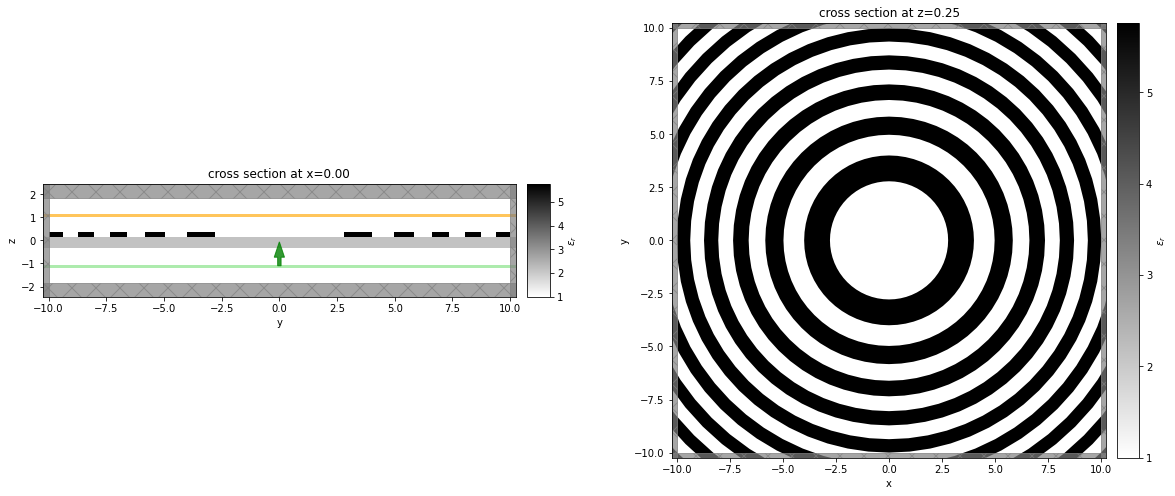

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
simulation.plot_eps(x=0, ax=ax1);
simulation.plot_eps(z=-length_z/2  + space_below_sub + height_sub + height_lens / 2, ax=ax2);

## Run Simulation

Now we can run the simulation and download the results


In [10]:
import tidy3d.web as web

sim_data = web.run(simulation, task_name='near2far', path='data/simulation.hdf5')

           INFO     Using Tidy3D credentials from stored file                      ]8;id=138201;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=824087;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#74\74]8;;\

[11:43:55] INFO     Uploaded task 'near2far' with task_id                       ]8;id=461095;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=648227;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#117\117]8;;\
                    'e1570998-8da5-4676-9387-d7fb74465254'.                                  

Output()

[11:43:59] INFO     status = queued                                             ]8;id=19927;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=758667;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#258\258]8;;\

Output()

[11:44:07] INFO     status = preprocess                                         ]8;id=981035;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=261314;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#270\270]8;;\

[11:44:08] INFO     Maximum flex unit cost: 1.29                                ]8;id=668842;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=856708;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#249\249]8;;\

[11:44:16] INFO     starting up solver                                          ]8;id=703764;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=56211;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[11:44:28] INFO     running solver                                              ]8;id=490197;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=879687;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#280\280]8;;\

Output()

[11:46:19] INFO     early shutoff detected, exiting.                            ]8;id=462614;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=911172;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#291\291]8;;\

           INFO     status = postprocess                                        ]8;id=264929;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=288774;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#297\297]8;;\

Output()

[11:46:34] INFO     status = success                                            ]8;id=133084;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=533534;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#303\303]8;;\

[11:46:35] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=851005;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=713296;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#575\575]8;;\
                    "data/simulation.hdf5"                                                   

Output()

[11:47:02] INFO     loading SimulationData from data/simulation.hdf5            ]8;id=448242;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=531827;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#397\397]8;;\

           WARNING  Structure at structures[53] has bounds that extend      ]8;id=479777;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=720476;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#299\299]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[53] has bounds that extend      ]8;id=141273;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=870492;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#299\299]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[53] has bounds that extend      ]8;id=464554;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=301117;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#299\299]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

           WARNING  Structure at structures[53] has bounds that extend      ]8;id=844524;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=342438;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#299\299]8;;\
                    exactly to simulation edges. This can cause unexpected                   
                    behavior. If intending to extend the structure to                        
                    infinity along one dimension, use td.inf as a size                       
                    variable instead to make this explicit.                                  

## Visualization 

Let's inspect the near field using the Tidy3D builtin field visualization methods.  
For more details see the documentation of [tidy3d.SimulationData](https://docs.simulation.cloud/en/latest/_autosummary/tidy3d.SimulationData.html#tidy3d-simulationdata).

<Figure size 1080x252 with 6 Axes>

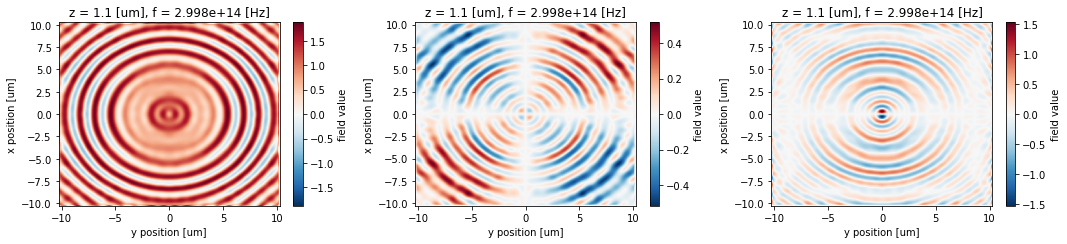

In [12]:
near_field_data = sim_data['nearfield']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))
near_field_data.Ex.real.plot(ax=ax1)
near_field_data.Ey.real.plot(ax=ax2)
near_field_data.Ez.real.plot(ax=ax3)
plt.show()

## Getting Far Field Data

The [Near2FarCartesianMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.Near2FarCartesianMonitor.html) object object ensures that the far field radiation vectors are already computed on the server during the simulation run.

The radiation vectors are building blocks that can be combined in various ways to quickly return various far field quantities such as fields, power, and radar cross section.

For this example, we use `Near2FarCartesianData.fields()` to get the fields at the previously-set `x,y,z` points.

In [13]:
far_fields = sim_data[monitor_far.name].fields()

## Plot Results
Now we can plot the near and far fields together

<Figure size 720x360 with 12 Axes>

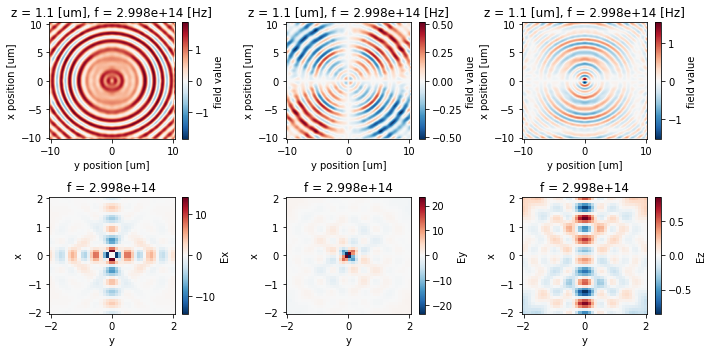

In [15]:
# plot everything
f, (axes_near, axes_far) =  plt.subplots(2, 3, tight_layout=True, figsize=(10, 5))

def pmesh(xs, ys, array, ax, cmap):
    im = ax.pcolormesh(xs, ys, array.T, cmap=cmap, shading='auto')
    return im

ax1, ax2, ax3 = axes_near
im = near_field_data.Ex.real.plot(ax=ax1)
im = near_field_data.Ey.real.plot(ax=ax2)
im = near_field_data.Ez.real.plot(ax=ax3)

ax1, ax2, ax3 = axes_far
im = far_fields['Ex'].real.plot(ax=ax1)
im = far_fields['Ey'].real.plot(ax=ax2)
im = far_fields['Ez'].real.plot(ax=ax3)

plt.show()

We can also use the far field data and plot the field intensity to see the focusing effect.

<Figure size 720x360 with 4 Axes>

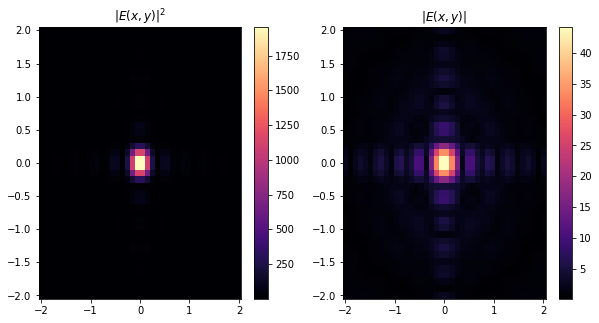

In [16]:
intensity_far = np.squeeze(
    np.square(np.abs(far_fields['Ex'].values)) +\
    np.square(np.abs(far_fields['Ey'].values)) +\
    np.square(np.abs(far_fields['Ez'].values))
)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

im1 = pmesh(xs_far, ys_far, intensity_far, ax=ax1, cmap='magma')
im2 = pmesh(xs_far, ys_far, np.sqrt(intensity_far), ax=ax2, cmap='magma')

ax1.set_title('$|E(x,y)|^2$')
ax2.set_title('$|E(x,y)|$')

plt.colorbar(im1, ax=ax1)
plt.colorbar(im2, ax=ax2)
plt.show()